# Chapter 7: Question Answering

## Building a Review-Based QA System

### The Dataset

> SubjQA is a question answering dataset that focuses on subjective (as opposed to factual) questions and answers. The dataset consists of roughly 10,000 questions over reviews from 6 different domains: books, movies, grocery, electronics, TripAdvisor (i.e. hotels), and restaurants. Each question is paired with a review and a span is highlighted as the answer to the question (with some questions having no answer). Moreover, both questions and answer spans are assigned a subjectivity label by annotators. Questions such as "How much does this product weigh?" is a factual question (i.e., low subjectivity), while "Is this easy to use?" is a subjective question (i.e., high subjectivity).
>
> In short, SubjQA provides a setting to study how well extractive QA systems perform on finding answer that are less factual and to what extent modeling subjectivity can improve the performance of QA systems.

Let's download the `subjqa` dataset and poke around a bit.

See the [Dataset card fof `subjqa` at HF](https://huggingface.co/datasets/subjqa).

In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")
subjqa.shape

{'train': (1295, 15), 'test': (358, 15), 'validation': (255, 15)}

In [3]:
import json

#print(subjqa["train"]["answers"][1])
print(json.dumps(
    subjqa["train"]["answers"][1], 
    indent=2
))

{
  "text": [
    "Bass is weak as expected",
    "Bass is weak as expected, even with EQ adjusted up"
  ],
  "answer_start": [
    1302,
    1302
  ],
  "answer_subj_level": [
    1,
    1
  ],
  "ans_subj_score": [
    0.5083333253860474,
    0.5083333253860474
  ],
  "is_ans_subjective": [
    true,
    true
  ]
}


In [4]:
print(json.dumps(
    subjqa["train"][1], 
    indent=2
))

{
  "domain": "electronics",
  "nn_mod": "harsh",
  "nn_asp": "high",
  "query_mod": "not strong",
  "query_asp": "bass",
  "q_reviews_id": "7c46670208f7bf5497480fbdbb44561a",
  "question_subj_level": 1,
  "ques_subj_score": 0.5,
  "is_ques_subjective": false,
  "review_id": "ce76793f036494eabe07b33a9a67288a",
  "id": "d476830bf9282e2b9033e2bb44bbb995",
  "title": "B00001P4ZH",
  "context": "To anyone who hasn't tried all the various types of headphones, it is important to remember exactly what these are: cheap portable on-ear headphones. They give a totally different sound then in-ears or closed design phones, but for what they are I would say they're good. I currently own six pairs of phones, from stock apple earbuds to Sennheiser HD 518s. Gave my Portapros a run on both my computer's sound card and mp3 player, using 256 kbps mp3s or better. The clarity is good and they're very lightweight. The folding design is simple but effective. The look is certainly retro and unique, although I

You see how `answers` has children `text`, `answer_start`, `answer_subj_level`, etc. 

If you want to explode the children of `answers` into their own columns, then use [`datasets.flatten`](https://huggingface.co/docs/datasets/process#flatten):

In [5]:
subjqa["validation"].flatten().features.to_dict()

{'domain': {'dtype': 'string', '_type': 'Value'},
 'nn_mod': {'dtype': 'string', '_type': 'Value'},
 'nn_asp': {'dtype': 'string', '_type': 'Value'},
 'query_mod': {'dtype': 'string', '_type': 'Value'},
 'query_asp': {'dtype': 'string', '_type': 'Value'},
 'q_reviews_id': {'dtype': 'string', '_type': 'Value'},
 'question_subj_level': {'dtype': 'int64', '_type': 'Value'},
 'ques_subj_score': {'dtype': 'float32', '_type': 'Value'},
 'is_ques_subjective': {'dtype': 'bool', '_type': 'Value'},
 'review_id': {'dtype': 'string', '_type': 'Value'},
 'id': {'dtype': 'string', '_type': 'Value'},
 'title': {'dtype': 'string', '_type': 'Value'},
 'context': {'dtype': 'string', '_type': 'Value'},
 'question': {'dtype': 'string', '_type': 'Value'},
 'answers.text': {'feature': {'dtype': 'string', '_type': 'Value'},
  '_type': 'Sequence'},
 'answers.answer_start': {'feature': {'dtype': 'int32', '_type': 'Value'},
  '_type': 'Sequence'},
 'answers.answer_subj_level': {'feature': {'dtype': 'int64', '_t

In [6]:
import pandas as pd

dfs = { 
    split: dset.to_pandas() 
    for split, dset 
    in subjqa.flatten().items() 
}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


Note that the `subjqa` dataset is quite small, but entirely in keeping with real-world scenarios since labelled data is very hard to find and expensive to create (you should know that!).

Now that we have transformed the `dataset` into `pandas.DataFrame`, we can use things like [`sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) to have a closer look...

In [7]:
qa_cols = [
    "title",
    "question",
    "answers.text",
    "answers.answer_start",
    "context"
]

sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [8]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

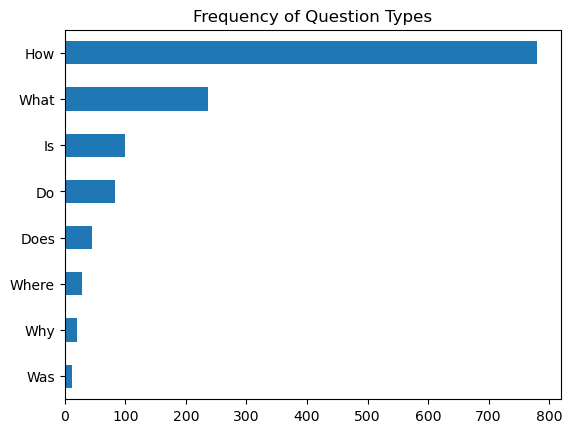

In [9]:
import matplotlib.pyplot as plt

counts = {}

question_types = [
    "What",
    "How",
    "Is",
    "Does",
    "Do",
    "Was",
    "Where",
    "Why"
]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [10]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)["question"]
    ):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## Extracting Answers from Text

On SQuAD2.0:

> Extractive reading comprehension systems can often locate the correct answer to a question in a context document, but they also tend to make unreliable guesses on questions for which the correct answer is not stated in the context. Existing datasets either focus exclusively on answerable questions, or use automatically generated unanswerable questions that are easy to identify. To address these weaknesses, we present SQuAD 2.0, the latest version of the Stanford Question Answering Dataset (SQuAD). SQuAD 2.0 combines existing SQuAD data with over 50,000 unanswerable questions written adversarially by crowdworkers to look similar to answerable ones. To do well on SQuAD 2.0, systems must not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering. SQuAD 2.0 is a challenging natural language understanding task for existing models: a strong neural system that gets 86% F1 on SQuAD 1.1 achieves only 66% F1 on SQuAD 2.0. 

Suggested reading:
* [SQuAD2.0 - The Stanford Question Answering Dataset](https://rajpurkar.github.io/SQuAD-explorer/)
* [Know What You Don't Know: Unanswerable Questions for SQuAD]() by Rajpurkar, Jia, and Liang, 2018
* [Question Answering on SQuAD2.0](https://paperswithcode.com/sota/question-answering-on-squad20) on paperswithcode.com

### Tokening text for QA

* Training dataset is small, with only 1295 examples.
* Since the structure of the labels for QA (predicting the start/end of an answer span) should be the same across datasets, starting from a fine-tuned, large-scale QA model is the sane approach.

We will use [`deepset/minilm-uncased-squad2`](https://huggingface.co/deepset/minilm-uncased-squad2#minilm-l12-h384-uncased-for-qa).

> Language model: microsoft/MiniLM-L12-H384-uncased<br/>
> Language: English<br/>
> Downstream-task: Extractive QA<br/>
> Training data: SQuAD 2.0<br/>
> Eval data: SQuAD 2.0<br/>
> Code: See an example QA pipeline on Haystack<br/>
> Infrastructure: 1x Tesla v100

In [11]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [12]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MG/minute, so about 6000 hours depending on file size."""

inputs = tokenizer(
    question,
    context,
    return_tensors="pt"
)

`inputs` has `input_ids` and `attention_mask` as expected, but notice how `token_type_id` indicate `0` for question token and `1` for context token. There should be a total of 28 tokens in the concatenation of `question` and `context`, including the tokens for `[CLS]` and `[SEP]`.

In [13]:
pd.DataFrame(
    dict(
        (k, v.tolist()[0]) 
        for k,v in inputs.items()
    )
).T

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [14]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mg / minute, so about 6000 hours depending on file size. [SEP]


In [15]:
import torch

from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-1.1286, -4.7415, -5.3876, -5.2379, -5.2723, -5.5013, -4.9711, -6.1821,
         -1.1286, -0.0502, -0.3999, -1.9431,  3.2140,  4.1175, -1.1694, -3.8895,
         -2.1539, -4.5801, -1.3942,  4.1693,  5.3227, -0.0295, -3.0786, -4.8637,
         -2.3779, -3.5348, -3.5455, -1.1286]]), end_logits=tensor([[-1.0579, -5.4757, -5.0125, -5.1458, -5.4216, -5.4915, -5.1583, -4.5826,
         -1.0580, -3.8277, -1.1060, -3.8418, -3.2789, -1.2299, -0.9271, -3.3560,
          4.1270,  0.2892, -3.2542, -3.1378,  1.0524,  5.8469, -0.2193, -4.8842,
         -3.3028, -0.1381,  1.6563, -1.0579]]), hidden_states=None, attentions=None)


In [16]:
# get the logits for the predictions of start/end indices...
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [17]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [18]:
# get the indices for start and end of the predicted answer span...
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1

# decode the answer span...
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)

print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


... and the same as above, but now wrapped in an [HF `pipeline` for Question Answering](https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.QuestionAnsweringPipeline)...

In [19]:
from transformers import pipeline

pipe = pipeline(
    "question-answering",
    model=model,
    tokenizer=tokenizer
)

pipe(
    question=question,
    context=context, 
    topk=5
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using /home/qackery/.cache/torch_extensions/py38_cu112 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Failed to load CUDA kernels. Mra requires custom CUDA kernels. Please verify that compatible versions of PyTorch and CUDA Toolkit are installed: CUDA_HOME environment variable is not set. Please set it to your CUDA install root.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/envs/transformers-py38/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:323: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.468392014503479, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.14781400561332703,
  'start': 32,
  'end': 48,
  'answer': 'about 6000 hours'},
 {'score': 0.14034169912338257,
  'start': 16,
  'end': 48,
  'answer': '1 MG/minute, so about 6000 hours'},
 {'score': 0.05686333402991295,
  'start': 10,
  'end': 48,
  'answer': 'about 1 MG/minute, so about 6000 hours'},
 {'score': 0.025132538750767708,
  'start': 16,
  'end': 27,
  'answer': '1 MG/minute'}]

In the case of a question for which no answer is possble, this model will assign a high start and end score to the `[CLS]` token, mapping the output to the empty string.

In [20]:
pipe(
    question="How many roads must a man walk?",
    context=context,
    handle_impossible_answer=True
)

{'score': 0.9904054999351501, 'start': 0, 'end': 0, 'answer': ''}

### Dealing with long passages

In [21]:
example = dfs["train"].iloc[0][["question", "context"]]

tokenized_example = tokenizer(
    example["question"],
    example["context"],
    return_overflowing_tokens=True,
    max_length=100,
    stride=25
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [22]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [23]:
for window in tokenized_example["input_ids"]:
    print(f"{window}")

[101, 2129, 2003, 1996, 3321, 1029, 102, 1045, 2031, 2018, 12849, 4757, 2132, 19093, 1999, 1996, 2627, 1010, 4013, 26424, 2050, 1998, 1053, 2480, 1011, 5585, 1012, 1996, 12849, 4757, 3417, 9331, 3217, 2003, 12109, 1998, 2038, 2307, 3321, 3433, 1012, 1996, 2147, 2307, 2007, 2026, 11924, 3042, 1998, 2064, 2022, 1000, 4565, 2039, 1000, 2000, 2022, 3344, 1999, 2026, 9055, 6598, 2030, 3274, 4524, 2302, 2893, 24514, 2098, 1012, 2027, 2024, 2200, 2422, 1998, 2079, 2025, 2514, 3082, 2030, 4562, 2091, 2006, 2115, 5551, 2130, 2044, 5962, 2000, 2189, 2007, 2068, 2006, 2035, 2154, 1012, 1996, 2614, 2003, 102]
[101, 2129, 2003, 1996, 3321, 1029, 102, 1998, 2079, 2025, 2514, 3082, 2030, 4562, 2091, 2006, 2115, 5551, 2130, 2044, 5962, 2000, 2189, 2007, 2068, 2006, 2035, 2154, 1012, 1996, 2614, 2003, 2305, 1998, 2154, 2488, 2084, 2151, 4540, 1011, 13007, 2071, 2022, 1998, 2024, 2471, 2004, 2204, 2004, 1996, 4013, 26424, 2050, 1012, 2027, 2024, 1000, 2330, 2250, 1000, 2132, 19093, 2061, 2017, 3685, 267

To clarify, here is are the first 75 tokens of the 100 tokens that make up the first window; along with the trailing 25 tokens that make up the stride (overlap). Tokens have been decoded.

In [24]:
print(f"Tokens 0 through 74 for window 0\n=====\n{tokenizer.decode(tokenized_example['input_ids'][0][7:-26])}")
print()
print(f"... and the last 25 tokens for window 0 making up the stride:\n=====\n{tokenizer.decode(tokenized_example['input_ids'][0][-26:])}")

Tokens 0 through 74 for window 0
=====
i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light

... and the last 25 tokens for window 0 making up the stride:
=====
and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP]


And here is what window 1 looks like:

In [25]:
print(f"Tokens 0 through 25 for the stride (overlapping) input continuation in window 1\n=====\n{tokenizer.decode(tokenized_example['input_ids'][1][7:7+25])}")
print()
print(f"... and the trailing remaining tokens for window 1\n=====\n{tokenizer.decode(tokenized_example['input_ids'][1][7+25:])}")

Tokens 0 through 25 for the stride (overlapping) input continuation in window 1
=====
and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is

... and the trailing remaining tokens for window 1
=====
night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP]


----

### Using Haystack to Build a QA Pipeline

<span style="background-color: #9AFEFF">_WARNING!!! The farm-haystack API has changed drastically since the writing of this book!_</span>

While referring to the [Quick Start on haystack.deepset.ai](https://haystack.deepset.ai/overview/quick-start), [Tutorial: Build Your First Question Answering System](https://haystack.deepset.ai/tutorials/01_basic_qa_pipeline), as well as [Tutorial: Evaluation of a QA System](https://haystack.deepset.ai/tutorials/05_evaluation) on the Haystack by deepset website, we will make appropriate changes.

#### Installing `farm-haystack`

This part will require the installation of `farm-haystack` (NOT to be confused with `haystack`!).

    pip install farm-haystack
    
    pip install 'farm-haystack[elasticsearch]' 

In [26]:
import os
from pathlib import Path
from subprocess import Popen, PIPE, STDOUT

#### Installing ElasticSearch

* The following code block downloads and install `elasticsearch`.
* This bit needs to be done only _once_!

#### Start `elasticsearch` server

Execute the following code block to start up `elasticsearch`.

In [27]:
# this will start up elasticsearch and create a PID file...
es_server = Popen(
    args=["elasticsearch-7.9.2/bin/elasticsearch", "-p", "pidfile"],
    stdout=PIPE,
    stderr=STDOUT
)

# wait until Elasticsearch has started..
!sleep 30

#### `curl` call to check `elasticsearch` server status

This `curl` call can be used to check if `elasticsearch` is running or not...

In [28]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "asia-east1-c-v100-n1-highmem-8",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "4sT5ste9TQC3V01DA2KiKg",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


#### Stop `elasticsearch` server

Execute the following code block to stop `elasticsearch`.

----

### Instantiate a document store

> You can think of the DocumentStore as a database that stores your texts and meta data
> and provides them to the Retriever at query time.<p/>
> By far the most common way to use a DocumentStore in Haystack is to fetch documents using a Retriever. You provide a DocumentStore as an argument when you initialize a Retriever.

In [29]:
from haystack.document_stores import ElasticsearchDocumentStore

# return the document embedding for later use with dense retriever
#                                                  ^^^^^
document_store = ElasticsearchDocumentStore(
    return_embedding=True
)

In [30]:
for split, df in dfs.items():
    # exclude duplicate reviews, i.e., no duplicated contexts
    docs = [{
        "content": row["context"],
        "meta": {
            "item_id": row["title"],
            "question_id": row["id"],
            "split": split}}
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")    

Loaded 1615 documents


### Initializing a retriever

> The Retriever performs document retrieval by sweeping through a DocumentStore and returning a set of candidate Documents that are relevant to the query. See what Retrievers are available and how to choose the best one for your use case.<p/>
> The Retriever is tightly coupled with the DocumentStore. You must specify a DocumentStore when initializing the Retriever.<p/>
> When used in combination with a Reader, the Retriever can quickly sift out irrelevant Documents, saving the Reader from doing more work than it needs to and speeding up the querying process.

The following kinds of retrievers are available in Haystack:

* `sparse`
* `dense`
* `multimodal`
* `web`
* `link_content`

#### Text Retrieval with `BM25Retriever`

>Use BM25 if you are looking for a retrieval method that doesn't need a neural network for indexing. BM25 is a variant of TF-IDF. It improves upon its predecessor in two main aspects:<p/>
> * It saturates `tf` after a set number of occurrences of the given term in the document
> * It normalises by document length so that short documents are favoured over long documents if they have the same amount of word overlap with the query

    
    


In [31]:
from haystack.nodes import BM25Retriever

es_retriever = BM25Retriever(
    document_store=document_store
)

In [32]:
item_id = "B0074BW614"
query = "Is it good for reading?"

retrieved_docs = es_retriever.retrieve(
    query=query,
    top_k=3,
    filters={
        "item_id": item_id,
        "split": ["train"]
    },
)

In [33]:
doc = retrieved_docs[0]
print(type(doc))
print()
print(json.dumps(doc.to_dict(), indent=2))

<class 'haystack.schema.Document'>

{
  "content": "This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.",
  "content_type": "text",
  "score": 0.6857824513476455,
  "meta": {
    "item_id": "B0074BW614",
    "question_id": "868e311275e26dbafe5af70774a300f3",
    "split": "train"
  },
  "id_hash_keys": [
    "content"
  ],
  "embedding": null,
  "id": "252e83e25d52df7311d597dc89eef9f6"
}


### Initializing a reader

> A Reader scans the texts it received from the Retriever and extracts the top answer candidates. Readers are based on powerful deep learning models but are much slower than Retrievers at processing the same amount of text.
> <br/>... from [Tutorial: Build Your First Question Answering System](https://haystack.deepset.ai/tutorials/01_basic_qa_pipeline)
> <br/><br/>MiniLM
> <br/>A distilled model that sacrifices a little accuracy for speed.
> <br/>Pro: 40% smaller, 50% faster inference speed, and better accuracy than BERT base.
> <br/>Con: Still doesn’t match the best base-sized models in accuracy.
> <br/>... from [Models, Haystack documentation](https://docs.haystack.deepset.ai/docs/reader#models)


In [34]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_len, doc_stride = 384, 128

reader = FARMReader(
    model_name_or_path="deepset/roberta-base-squad2", 
    progress_bar=False,
    max_seq_len=max_seq_len,
    doc_stride=doc_stride,
    return_no_answer=False  # let's not bother with no-answer responses!
)

In [35]:
res = reader.predict_on_texts(
    question=question, 
    texts=[context],
    top_k=1
)

print(f"Q: {res['query']}")
print(f"A: {res['answers'][0].answer}")

Q: How much music can this hold?
A: 6000 hours


#### Putting it all together

The [API for `ExtractiveQAPipeline`](https://docs.haystack.deepset.ai/reference/pipelines-api#extractiveqapipeline) appears to have changed drastically:

* `top_k_retrievers` is gone as direct parameter; use `params` and `Retriever` node name
* `top_k_readers` is gone as direct parameter; use `params` and `Reader` node name
* `filters` s gone as direct parameter; [use `params` and `filters` to filter results by using `meta` fields](https://docs.haystack.deepset.ai/docs/metadata-filtering#basic-filters)

In [36]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(
    retriever=es_retriever,
    reader=reader
)

In [37]:
n_answers = 3

preds = pipe.run(
    query=query,
    params={
        "filters": {
            "item_id": item_id,
            "split": ["train"]
        },
        "Retriever": {"top_k": 3},
        "Reader": {"top_k": 3}
    },
)

answers = [ans for ans in preds['answers'] ]

In [38]:
print(f"Question: {preds['query']}\n")

for i,answer in enumerate(answers):
    print(f"Answer {i+1}: {answer.answer}")
    print(f"Review snippet: ...{answer.context}\n")

Question: Is it good for reading?

Answer 1: it is great for reading books
Review snippet: ...myself after becoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest goo

Answer 2: It's light enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading
Review snippet: ...t perfect for me. It's light enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading. I love the colo

Answer 3: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la



### Evaluating the Retriever

Following the example of [Tutorial: Evaluation of a QA System](https://haystack.deepset.ai/tutorials/05_evaluation), let's just start from a brand-new document store.

We begin with setting up a new document store in Elastic, explicitly specifying an `index` and `label_index`.

In [39]:
# make sure these indices do not collide with existing ones, 
# the indices will be wiped clean before data is inserted
doc_index = "test_docs"
label_index = "test_labels"

# Elasticsearch document store specifically for calculating precision
# on the "test" data...
test_document_store = ElasticsearchDocumentStore(
    index=doc_index,
    label_index=label_index,
    return_embedding=True
)

Sanity check on our `test_document_store`, which might not be empty if we are repeatedly executing these code blocks.

In [40]:
if test_document_store.get_document_count() > 0:
    test_document_store.delete_documents()
if test_document_store.get_label_count() > 0:
    test_document_store.delete_labels()

# check!
print(f"document count: {test_document_store.get_document_count()}")
print(f"label count:    {test_document_store.get_label_count()}")

document count: 0
label count:    0


#### Load up documents from the `test` dataset

_... wonder why the book doesn't use the `validation` dataset?_

In [41]:
df = dfs["test"]

# exclude duplicate reviews?
docs = [{
    "content": row["context"],
    "meta": {
        "item_id": row["title"],
        "question_id": row["id"],
        "split": "test"}}
    for _,row in df.drop_duplicates(subset="context").iterrows()]

test_document_store.write_documents(
    docs, 
    index=doc_index
)
    
print(f"Loaded {test_document_store.get_document_count()} documents")    

Loaded 358 documents


#### Create and load up `Label`s from `test`

For QA, the _"labels"_ are spans that indicate the start and end indices of the correct answer to the corresponding question.

Here, we create the labels for the answers to questions in the `test` dataset manually.

Please see the following APIs for Haystack primitivies:
* [`Label`](https://docs.haystack.deepset.ai/reference/primitives-api#label)
* [`Answer`](https://docs.haystack.deepset.ai/reference/primitives-api#answer)
* [`Span`](https://docs.haystack.deepset.ai/reference/primitives-api#span)

In [42]:
from haystack import Label, Answer, Span

labels = []
for _, row in df.iterrows():
    meta = {
        "item_id": row["title"],
        "question_id": row["id"],
        "split": "test"
    }

    document = test_document_store.get_all_documents(
        filters={"item_id": row["title"], "question_id": row["id"]}
    )[0]

    if len(row["answers.text"]):
        for i,answer in enumerate(row["answers.text"]):
            sidx = row["answers.answer_start"][i]
            eidx = sidx + len(answer)
            
            label = Label(
                query=row["question"],
                document=document,
                is_correct_answer=True,
                is_correct_document=True,
                origin="gold-label",
                answer=Answer(
                    answer=answer, 
                    type="extractive",
                    offsets_in_document=[Span(sidx, eidx)]
                ),
                meta=meta
            )
            labels.append(label)
    else:
        label = Label(
            query=row["question"],
            document=document,
            is_correct_answer=True,
            is_correct_document=True,
            origin="gold-label",
            answer=None,
            meta=meta
        )
        labels.append(label)

test_document_store.write_labels(
    labels,
    index=label_index
)

print(f"Loaded {test_document_store.get_label_count()} question-answer pairs")

Loaded 455 question-answer pairs


#### Now gather up the `Label` instances for evaluation...

Most of the following comes from the Advanced [Evaluation of a QA System tutorial](https://haystack.deepset.ai/tutorials/05_evaluation) on Haystack. Please see API documentation for [`BaseDocumentStore.get_all_labels_aggregated`](https://docs.haystack.deepset.ai/reference/document-store-api#basedocumentstoreget_all_labels_aggregated).

The key points here when gathering up the `Label` instances for our evaluation of the retriever are:
* explicitly specify the document store index for the `Label`s
* explicitly specify `open_domain=True` as the questions being asked of the full collection of documents in the dataset
* use `aggregate_by_meta` to explicity specify the identification key in our documents (not the default `Document` key!)
* set `drop_negative_labels` and `drop_no_answers` to `True` per the tutorial


<span style="background-color: #9AFEFF">**WARNING!!!**</span>
* <span style="background-color: #9AFEFF">If you do not explicitly specify `drop_negative_labels=True`, then you will see `ValueError: max() arg is an empty sequence`!</span>
* <span style="background-color: #9AFEFF">And if you don't set `drop_no_answers=True`, then you may see errors where a no-answer `Label` is returned.</span>



In [43]:
eval_labels = test_document_store.get_all_labels_aggregated(
    index=label_index,
    open_domain=True,
    aggregate_by_meta=["item_id"],
    drop_negative_labels=True,         # **** IMPORTANT: see Evaluation of an ExtractiveQAPipeline
    drop_no_answers=True               # ****
)
print(len(eval_labels))

151


In [44]:
a_label = eval_labels[100].labels[0]

print(a_label)
print()
print(a_label.query)
print(a_label.answer)

<Label: {'id': '64b7a9e5-b8c9-4f58-9131-39eeabd5903b', 'query': 'How is the antenna?', 'document': {'id': '18680bbc245a4c7a134435a8ac6cb69a', 'content': 'Methods: I tested my current indoor antenna while attached to a Samsung TV, which has the strongest receiver of any of the TVs in my home. I first scanned for channels with my current antenna attached. I then disconnected my antenna and immediately attached the Winegard FlatWave. I oriented it in the same direction used for my current antenna, which is toward the closest major city (about 30 miles away). I also placed the FlatWave as high as possible in the room. I then re-scanned for channels.Results: My original antenna picked up 31 channels. The Winegard FlatWave picked up 12. The difference is that the Winegard antenna picked up only stations from the direction the antenna was pointed, while my current antenna also picks up stations from 3 nearby cities in other directions.Discussion: My current antenna is a DB4 multi-directional 

----

#### Set up an `ExtractiveQAPipeline` for test purposes

In [45]:
test_pipe = ExtractiveQAPipeline(

    retriever=BM25Retriever(
        document_store=test_document_store
    ), 

    reader=reader
)

In [46]:
# We can run the pipeline with the desired top_k value like this
eval_result = test_pipe.eval(
    labels=eval_labels,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

In [47]:
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Recall@3: 0.91


#### Calculate the recall for the retriever across different values of `top_k`

In [48]:
import pandas as pd

def evaluate_retriever(pipeline, eval_labels, topk_values=[1,3,5,10,20]):
    topk_results = {}

    for k in topk_values:
        eval_result = pipeline.eval(
            labels=eval_labels, 
            params={"Retriever": {"top_k": k}}
        )
        metrics = eval_result.calculate_metrics()
        topk_results[k] = {
            "recall_single_hit": metrics["Retriever"]["recall_single_hit"],
            "recall_multi_hit": metrics["Retriever"]["recall_multi_hit"]
        }
    return pd.DataFrame.from_dict(topk_results, orient="index")

es_topk_df = evaluate_retriever(test_pipe, eval_labels)
print(es_topk_df)

    recall_single_hit  recall_multi_hit
1            0.774834          0.758278
3            0.913907          0.907837
5            0.966887          0.960265
10           0.993377          0.993377
20           0.993377          0.993377


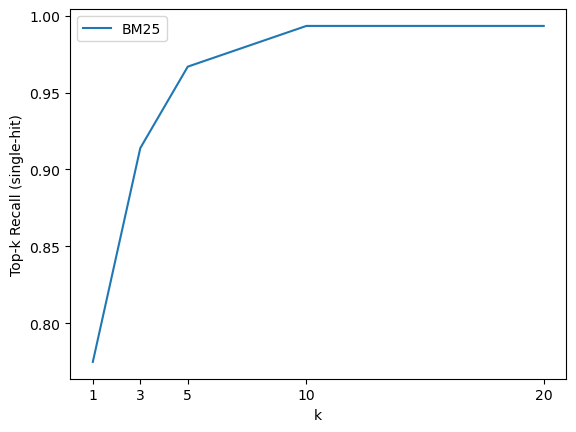

In [49]:
def plot_receiver_eval(dfs, retrievers):
    fig, ax = plt.subplots()
    for df, r in zip(dfs, retrievers):
        df.plot(y="recall_single_hit", ax=ax, label=r)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall (single-hit)")
    plt.xlabel("k")
    plt.show()

plot_receiver_eval([es_topk_df], ["BM25"])

----

#### Now try out `DensePassageRetriever`

> Dense Passage Retrieval is a retrieval method that calculates relevance using dense representations. Key features:
>
> * One BERT base model to encode documents
> * One BERT base model to encode queries
> * Ranking of Documents done by dot product similarity between query and document embeddings
>
> Indexing using DPR is comparatively expensive in terms of required computation since all documents in the database need to be processed through the transformer. In order to keep query times low, you should store these embeddings in a vector-optimized database such as FAISS or Milvus.



You also might like:
* read [Karpukhin, et al, "Dense Passage Retrieval for Open-Domain Question Answering", (2020)](https://arxiv.org/pdf/2004.04906.pdf)
* view [Stanford CS224N NLP with Deep Learning | Winter 2021 | Lecture 11 - Question Answering](https://www.youtube.com/watch?v=NcqfHa0_YmU&list=PLoROMvodv4rOSH4v6133s9LFPRHjEmbmJ&index=11) (guest presenter Danqi Chen is one of the authors on the above paper!)

> In Haystack, you can download the pre-trained encoders needed to start using DPR. For DPR, you need to provide two models - one for the query and one for the documents, however, _**the models must be trained on the same data**_. The easiest way to start is to go to Hugging Face and search for `dpr`. You'll get a list of DPR models sorted by Most Downloads, which means that the models at the top of the list are the most popular ones. Choose a `ctx_encoder` and a `question_encoder` model. 

In [50]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(
    document_store=test_document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False
)

#### Update the embeddings used in `test_document_store`

Now that we have an instance of `DensePassageRetriever`, we need to iterate over the documents in `test_document_store` and apply the encoders to update corresponding embedding representations.

Since we originally set `return_embedding=True` when we initially created `test_document_store`, all we need is to do this:

In [51]:
test_document_store.update_embeddings(dpr_retriever)

Create embeddings:  96%|██████████████████████████████████████████████▊  | 352/368 [00:01<00:00, 232.83 Docs/s]
Updating embeddings: 10000 Docs [00:03, 2537.26 Docs/s]                                                        


In [52]:
test_pipe2 = ExtractiveQAPipeline(

    retriever=dpr_retriever, 

    reader=reader
)

In [53]:
dpr_topk_df = evaluate_retriever(test_pipe2, eval_labels)
print(dpr_topk_df)

    recall_single_hit  recall_multi_hit
1            0.635762          0.618102
3            0.913907          0.896799
5            0.966887          0.963576
10           1.000000          1.000000
20           1.000000          1.000000


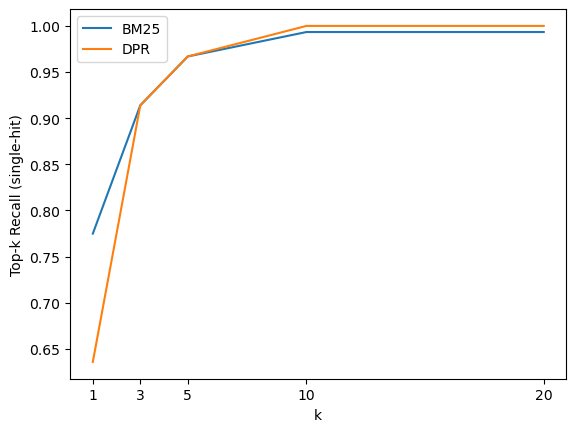

In [54]:
plot_receiver_eval([es_topk_df, dpr_topk_df], ["BM25", "DPR"])

----

### Evaluating the Reader

The current API for Haystack does not seem to provide functions that work like the `compute_f1` and `compute_exact` mentioned in Evaluating the Reader, pages 196 and 197, Chapter 7.

In [55]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [56]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


In [57]:
from haystack.pipelines import Pipeline

def evaluate_reader(reader, eval_labels):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=eval_labels,
        documents= [[label.document for label in multilabel.labels] for multilabel in eval_labels],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
                
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader, eval_labels)

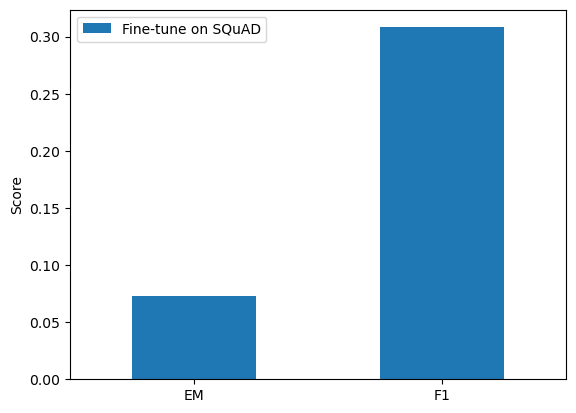

In [58]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

#### Metric Calculation from the Tutorial

Let's also try running the code from the Calculating Evaluation Metrics section of the [Evaluation of a QA System tutorial](https://haystack.deepset.ai/tutorials/05_evaluation) for Haystack.

In [59]:
test_pipe3 = ExtractiveQAPipeline(
    
    reader=reader, 
    
    retriever=dpr_retriever
)


eval_labels = test_document_store.get_all_labels_aggregated(
    index=label_index,
    open_domain=True,
    aggregate_by_meta=["item_id"],
    drop_negative_labels=True,         # **** IMPORTANT: see Evaluation of an ExtractiveQAPipeline
    drop_no_answers=True               # ****
)


eval_result = test_pipe3.eval(
    
    labels=eval_labels, 
    
    params={"Retriever": {"top_k": 5}}
)

In [60]:
metrics = eval_result.calculate_metrics()

print(f'Reader - F1-Score: {metrics["Reader"]["f1"]}')
print(f'Reader - Exact Match: {metrics["Reader"]["exact_match"]}')

Reader - F1-Score: 0.34358783750754357
Reader - Exact Match: 0.0728476821192053


#### Advanced Evaluation Metrics

> As an advanced evaluation metric, semantic answer similarity (SAS) can be calculated. This metric takes into account whether the meaning of a predicted answer is similar to the annotated gold answer rather than just doing string comparison. To this end SAS relies on pre-trained models. For English, we recommend `cross-encoder/stsb-roberta-large`, whereas for German we recommend `deepset/gbert-large-sts`. A good multilingual model is `sentence-transformers/paraphrase-multilingual-mpnet-base-v2`. 

In [61]:
advanced_eval_result = test_pipe3.eval(
    
    labels=eval_labels, 
    
    params={"Retriever": {"top_k": 5}}, 
    
    sas_model_name_or_path="cross-encoder/stsb-roberta-large"
)

metrics = advanced_eval_result.calculate_metrics()

print(f'Reader - SAS: {metrics["Reader"]["sas"]}')

Reader - SAS: 0.4747365117073059


#### Isolated Evaluation Mode

> The isolated node evaluation uses labels as input to the Reader node instead of the output of the preceeding Retriever node. Thereby, we can additionally calculate the upper bounds of the evaluation metrics of the Reader. Note that even with isolated evaluation enabled, integrated evaluation will still be running.

In [62]:
eval_result_with_upper_bounds = test_pipe3.eval(
    
    labels=eval_labels, 
    
    params={
        "Retriever": {"top_k": 5}, 
        "Reader": {"top_k": 5}
    },
    
    add_isolated_node_eval=True
)

test_pipe3.print_eval_report(eval_result_with_upper_bounds)

================== Evaluation Report ==================
                   Pipeline Overview
                      Query
                        |
                        |
                      Retriever
                        |
                        | recall_single_hit: 0.967
                        |
                      Reader
                        |
                        | exact_match upper bound: 0.0795
                        | exact_match: 0.0728
                        | exact_match_top_1: 0.0662
                        | f1 upper bound:  0.33
                        | f1: 0.342
                        | f1_top_1: 0.237
                        | num_examples_for_eval upper bound: 1.51e+02
                        | num_examples_for_eval: 1.51e+02
                        | num_examples_for_eval_top_1: 1.51e+02
                        |
                      Output

                Wrong Retriever Examples
Query: 
 	What is the weight of the thing?
Gold Document Ids: 
 	b

----

### Domain Adaptation